In [1]:
""" First attempt to build a ConvNet in Keras
	for CV (Computer Vision), more specifically for 
	Image Recognition (classification problem).
"""

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K 
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Sequential
from keras.optimizers import Optimizer
from keras.callbacks import EarlyStopping
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping

# For reproducibility
np.random.seed(42)

Using TensorFlow backend.


In [2]:
"""Retrieve the CIFAR dataset and process the data."""

classes = ["airplane", "automobile ", "bird ", "cat" , "deer", "dog", "frog" , "horse", "ship", "truck"]
nb_classes = 10
batch_size = 64
input_dim = 32*32*3
nb_train = 50000
nb_test = 10000
# Get the data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Preprocess it
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Cifar 10 data retrieved and processed")

Cifar 10 data retrieved and processed


In [5]:
# Swish activation function
# x*sigmoid(x)
def swish(x):
    return x*K.sigmoid(x)

# Custom activation function 1
# mix between relu and positive part of swish mirrored across x=1
def e_swish_1(x):
    return K.maximum(0.0, x*(2-K.sigmoid(x)))

# Custom activation function 2
# positive part of swish mirrored across x=1
def e_swish_2(x):
    return K.maximum(x*K.sigmoid(x), x*(2-K.sigmoid(x)))

def leaky(x, alpha=0.3):
    return K.maximum(x*0.3, x)

In [9]:
activations = [e_swish_2, swish, "relu", "elu", leaky] # e_swish_1, 
names = activations[:]
for i,a in enumerate(names):
    if not isinstance(a, str):
        names[i] = a.__name__
print(names)

['e_swish_2', 'swish', 'relu', 'elu', 'leaky']


In [5]:
def create_models():
    models = []

    # create models - ALCAIDES, SWISH, RELU, DIGMOID, TANH
    for act in activations:
        model = Sequential()
        # First Convolutional Block
        model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=act, input_shape=x_train.shape[1:]))
        model.add(MaxPooling2D(pool_size = 2))
        model.add(Dropout(0.15))
        model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=act))
        model.add(MaxPooling2D(pool_size = 2))
        model.add(Dropout(0.15))
        # Second Convolutional Block
        model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=act))
        model.add(Dropout(0.15))
        model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation=act))
        model.add(MaxPooling2D(pool_size = 2))
        model.add(Dropout(0.15))
        # Last Convolutional Block
        model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation=act))
        model.add(MaxPooling2D(pool_size = 2))
        model.add(Dropout(0.15))
        # Flatten and pass trough fully connected layers
        model.add(Flatten())
        # Classification task
        model.add(Dense(64, activation=act))
        model.add(Dense(10, activation='softmax'))
        models.append(model)

    # Compile models
    for model in models:
        model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
    
    # Create Accuracy history
    acc = []
    for model in models: acc.append([0])
        
    return models, acc

In [3]:
def test_against(models, epochs, acc):
    for j in range(epochs):
        for i,model in enumerate(models):
            print("Training model {0}".format(i))
            model.fit(x_train, y_train, epochs=1, batch_size=128,  verbose=1, shuffle=True, validation_split=0.1)
            scores = model.evaluate(x_test, y_test)
            acc[i].append(scores[1]*100)
        print("\n")
        print("///////////////////////////////////////////////")
        print("/////////////////////{0}//////////////////////////".format(j+1))
        print("///////////////////////////////////////////////")

    return models, acc

# Plot the evolution of the accuracies
def plot_results(accs):
	plt.figure()
	for acc in accs:
		plt.plot(100-np.array(acc))
	plt.grid()
	plt.legend(names, loc='upper right')
	plt.show()

In [7]:
kernels, acc = create_models()
print(len(kernels))

5


In [8]:
# visualize model structure
kernels[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
__________

In [9]:
kernels, acc = test_against(kernels, 15, acc)

Training model 0
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 5s 472us/step
Training model 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 391us/step
Training model 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 359us/step
Training model 3
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 373us/step
Training model 4
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 394us/step


///////////////////////////////////////////////
/////////////////////1//////////////////////////
///////////////////////////////////////////////
Training model 0
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 448us/step
Training model 1
Train on 45000

10000/10000 [==============================] - 4s 391us/step
Training model 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 362us/step
Training model 3
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 381us/step
Training model 4
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 389us/step


///////////////////////////////////////////////
/////////////////////12//////////////////////////
///////////////////////////////////////////////
Training model 0
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 450us/step
Training model 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 381us/step
Training model 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [=================

In [10]:
kernels, acc = test_against(kernels, 5, acc)

Training model 0
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 5s 469us/step
Training model 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 395us/step
Training model 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 359us/step
Training model 3
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 380us/step
Training model 4
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 384us/step


///////////////////////////////////////////////
/////////////////////1//////////////////////////
///////////////////////////////////////////////
Training model 0
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 5s 453us/step
Training model 1
Train on 45000

<IPython.core.display.Javascript object>


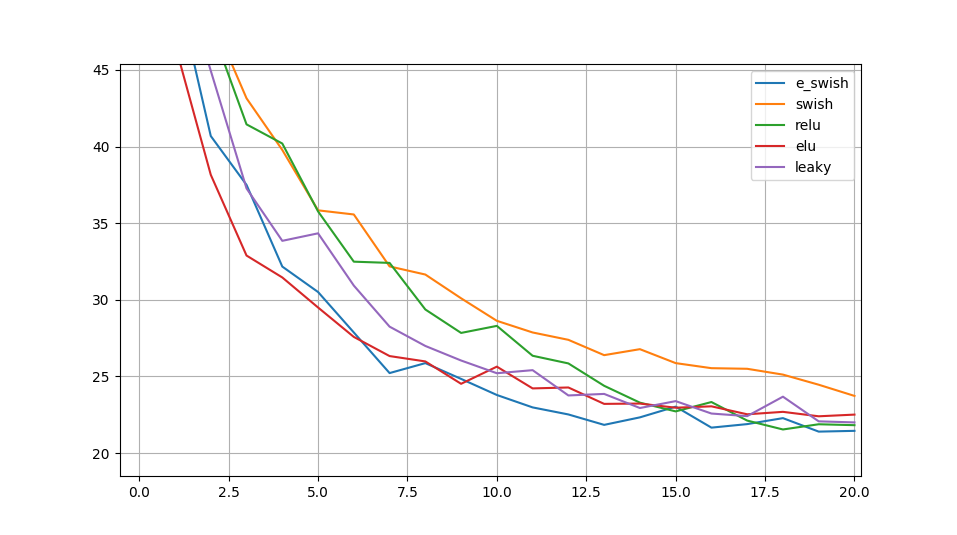

[[0, 49.16, 59.309999999999995, 62.5, 67.83, 69.49, 72.13000000000001, 74.78, 74.13, 75.16000000000001, 76.21, 77.02, 77.48, 78.16, 77.66999999999999, 76.97, 78.34, 78.11, 77.72, 78.60000000000001, 78.55], [0, 42.809999999999995, 51.43, 56.85, 60.22, 64.16, 64.42999999999999, 67.82000000000001, 68.35, 69.89999999999999, 71.37, 72.13000000000001, 72.61, 73.61, 73.22, 74.13, 74.46000000000001, 74.5, 74.88, 75.53999999999999, 76.27000000000001], [0, 42.86, 52.129999999999995, 58.550000000000004, 59.8, 64.23, 67.51, 67.58999999999999, 70.63000000000001, 72.16, 71.7, 73.65, 74.15, 75.61, 76.71, 77.28, 76.67, 77.88000000000001, 78.46, 78.12, 78.18], [0, 53.339999999999996, 61.839999999999996, 67.11, 68.54, 70.5, 72.42, 73.67, 74.02, 75.48, 74.36, 75.78, 75.72, 76.79, 76.77000000000001, 77.03999999999999, 76.95, 77.47, 77.31, 77.60000000000001, 77.49000000000001], [0, 47.339999999999996, 55.05, 62.73, 66.14999999999999, 65.66, 69.07, 71.75, 73.00999999999999, 73.96000000000001, 74.79, 74.59, 

In [10]:
# New (paper writing)
%matplotlib notebook
plot_results(acc)
print(acc)

<IPython.core.display.Javascript object>


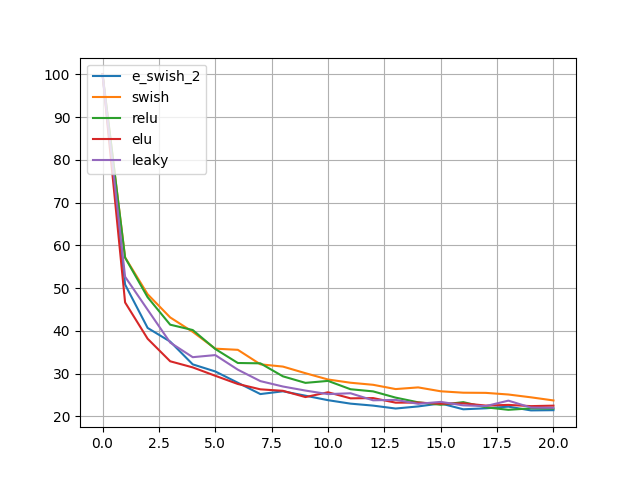

In [13]:
# Original (first day)
%matplotlib notebook
plot_results(acc)